In [39]:
'''
This is code for extracting NN features of face image data 
and then fit a linear model to predict attractiveness of a face
Available dataset: TWIN, CHICAGO and MIT
Available NN feature: 'caffeNet','vgg16','vggFace' and 'faceSNN'

BY Linjie Li
Please run this code on guru2 server
'''
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import os

from sklearn.decomposition import PCA as sklearnPCA

# Make sure that caffe is on the python path:
caffe_root = '/home/lli-ms/caffe/'
pretrained_model_root = '/home/lli-ms/caffe/'

# run this line one time only!
import sys
caffePython = pretrained_model_root + 'python'
if caffePython not in sys.path:
    sys.path.insert(0, caffePython)


import caffe
# Load mean
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# Load the trained net
MODEL = 'vgg16_attr' #'caffeNet','vgg16','vggFace' or 'faceSNN'

# saveFigPath = '../Result/'+Dataset+'/'+MODEL
# if not os.path.exists(saveFigPath):
#     os.makedirs(saveFigPath)
    
if MODEL == 'vgg16_attr':
    MODEL_FILE ='../neuralNet/VGG16/vgg16_attr_deploy.prototxt'
    PRETRAINED_FILE = caffe_root +'models/vgg16_attr/vgg16_attr_min_10pca_weight_scale.caffemodel'
    #'models/vgg16_attr/snapshots/first_train_iter_2000.caffemodel'
    #'models/vgg16_attr/vgg16_attr_max_1000pca_weight_position.caffemodel'
elif MODEL == 'caffeNet':
    MODEL_FILE = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
    PRETRAINED_FILE = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
elif MODEL == 'vggFace':
    MODEL_FILE = caffe_root + 'models/VGGFACE/VGG_CNN_F_deploy.prototxt'
    PRETRAINED_FILE = caffe_root + 'models/VGGFACE/VGG_CNN_F.caffemodel'
    MEAN_FILE = caffe_root + 'models/VGGFACE/VGG_mean.binaryproto'
else:
    MODEL = 'faceSNN'
    MODEL_FILE = caffe_root +'models/sraonet/siamese_lecun_deploy.prototxt'
    PRETRAINED_FILE = caffe_root + 'models/sraonet/snapshots/sraonet_lecun_gd_sub2_iter_100000.caffemodel'
    
caffe.set_device(2)
caffe.set_mode_gpu()
if not os.path.isfile(PRETRAINED_FILE):
    print("No caffemodel!!!")
elif not os.path.isfile(MODEL_FILE):
    print("No MODEL !!!")
else:
    print "Defining the net!"
    net = caffe.Net(MODEL_FILE,
                PRETRAINED_FILE,
                caffe.TEST)
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
if MODEL != 'faceSNN':
    # subtract the dataset-mean value in each channel
    transformer.set_mean('data', mu)
layersParam = dict()
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)
    layersParam[layer_name]=param
transformer.set_transpose('data', (2,0,1))
# the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_raw_scale('data', 255) 
# the reference model has channels in BGR order instead of RGB
transformer.set_channel_swap('data', (2,1,0))


mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
Defining the net!
conv1_1	(64, 3, 3, 3) (64,)
conv1_2	(64, 64, 3, 3) (64,)
conv2_1	(128, 64, 3, 3) (128,)
conv2_2	(128, 128, 3, 3) (128,)
conv3_1	(256, 128, 3, 3) (256,)
conv3_2	(256, 256, 3, 3) (256,)
conv3_3	(256, 256, 3, 3) (256,)
conv4_1	(512, 256, 3, 3) (512,)
conv4_2	(512, 512, 3, 3) (512,)
conv4_3	(512, 512, 3, 3) (512,)
conv5_1	(512, 512, 3, 3) (512,)
conv5_2	(512, 512, 3, 3) (512,)
fc_pca	(255, 100352) (255,)
fc_out	(1, 255) (1,)


In [40]:
if MODEL == 'vgg16_attr':
    imgeReshape = [224,224]
    featureLayer = 'fc_pca' 
if 'fc' in featureLayer:
    featureNum = net.params[featureLayer][1].data.shape[0]
else:
    featureNum = net.blobs[featureLayer].data.flatten().shape[0]/net.blobs[featureLayer].data.shape[0]

In [41]:
fc_pcaWeight = layersParam['fc_pca'][0].data
print fc_pcaWeight.max()
np.nonzero(fc_pcaWeight)

0.00353254


(array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10]),
 array([12397, 15253, 15254, 15267, 15268, 54425, 54439, 64827, 77259, 77260]))

In [42]:
test_file = '../data_list/val_list.txt'
train_file = '../data_list/train_list.txt'
def readFile(fName):
    text_file = open(fName, "r")
    lines = text_file.read().split('\n')
    text_file.close()
    imList = []
    ratingList = []
    for l in lines:
        if len(l) > 2:
            l_split = l.split('.jpg ')
            #print l_split
            imList.append(l_split[0]+'.jpg')
            ratingList.append(float(l_split[1]))
    return imList,ratingList

testIm, testRating = readFile(test_file)
trainIm, trainRating = readFile(train_file)
from scipy.stats import spearmanr as spearmanr


X_test = np.zeros([len(testIm)])
totalNum = 0
for img in testIm:
    imgName = os.path.basename(img)
    if imgName.endswith(('.jpg','.png')):
        input_image = caffe.io.load_image(img)
        net.blobs['data'].reshape(1,3,imgeReshape[0],imgeReshape[1])
        net.blobs['data'].data[...] = transformer.preprocess('data', input_image)
        out = net.forward()
        feat = net.blobs[featureLayer].data
        X_test[totalNum] = feat.flatten()[10]
        #print features[totalNum]
        totalNum +=1
    else:
        print img
        
X_train = np.zeros([len(trainIm)])
totalNum = 0
for img in trainIm:
    imgName = os.path.basename(img)
    if imgName.endswith(('.jpg','.png')):
        input_image = caffe.io.load_image(img)
        net.blobs['data'].reshape(1,3,imgeReshape[0],imgeReshape[1])
        net.blobs['data'].data[...] = transformer.preprocess('data', input_image)
        out = net.forward()
        feat = net.blobs[featureLayer].data
        X_train[totalNum] = feat.flatten()[10]
        #print features[totalNum]
        totalNum +=1
    else:
        print img

In [43]:
X_train.shape = (1765,1)
print X_train.shape
trainRating = np.asarray(trainRating)
X_test.shape = (X_test.shape[0],1)
print trainRating.shape
testRating = np.asarray(testRating)

(1765, 1)
(1765,)


In [44]:
from sklearn import linear_model
# Do linear regression on feature_arr and mean_rating
regr = linear_model.Ridge(fit_intercept=True)
regr.fit(X_train, trainRating)
train_predict = regr.predict(X_train)

# Calculate the correlation between prediction and actual rating.
cor = np.corrcoef(train_predict, trainRating)
print cor[0,1]
rcor = spearmanr(trainRating, train_predict)
print rcor[0]

test_predict = regr.predict(X_test)
# Calculate the correlation between prediction and actual rating.
cor = np.corrcoef(test_predict, testRating)
print cor[0,1]
rcor = spearmanr(testRating, test_predict)
print rcor[0]

7.53423656444e-16
nan
nan
nan


In [45]:
allPredict = np.concatenate([train_predict,test_predict]).tolist()
allIm = trainIm + testIm
sortedIm = [x for (y,x) in sorted(zip(allPredict,allIm))]
sortedRating = [y for (y,x) in sorted(zip(allPredict,allIm))]

print sortedRating[0]
print sortedRating[-1]

4.9370303796
4.9370303796


In [3]:
#pink image 
# Load image dataset#
Dataset = 'white_noise' # 'twin', 'chicago' or 'mit', 'zhihu','pink_noise' or 'funnyFace'
if Dataset == 'twin':
    imPath = '../../processing/imageProcessing/paddedImages/'
    ext = '.png'
elif Dataset == 'chicago':
    imPath = '../../ChicagoFaceDataset/CFD Version 2.0/CFD 2.0 Images/'
    ext = 'N.jpg'
elif Dataset == 'mit':
    imPath = '../../MIT2kFaceDataset/2kfaces/'
    ext = '.jpg'
elif Dataset =='funnyFace':
    imPath = '../funnyFace/'
    ext = '.png'
elif Dataset =='pink_noise':
    imPath = '../pink_noise_image/'
    ext = '.png'
else: #Dataset =='white_noise':
    imPath = '../white_noise_image/'
    ext = '.png'
imList = []
for dirpath, dirnames, filenames in os.walk(imPath):
    for filename in [f for f in filenames if f.endswith(ext)]:
        imList.append(os.path.join(dirpath, filename))
imList.sort()
print len(imList)

10000


In [4]:
def writeFile(fName,data):
    text_file = open(fName, "w")
    for d in data:
        d = d + '\n'
        text_file.write(d)
    text_file.close()
fName = '../data_list/pink_image_list.txt'    
writeFile(fName, imList)

In [6]:
pink_predict = np.zeros([len(imList)])
totalNum = 0
featureLayer = 'fc_out'
for img in imList:
    imgName = os.path.basename(img)
    if imgName.endswith(('.jpg','.png')):
        input_image = caffe.io.load_image(img)
        net.blobs['data'].reshape(1,3,imgeReshape[0],imgeReshape[1])
        net.blobs['data'].data[...] = transformer.preprocess('data', input_image)
        out = net.forward()
        feat = net.blobs[featureLayer].data
        pink_predict[totalNum] = feat.flatten()
        #print features[totalNum]
        totalNum +=1
    else:
        print img

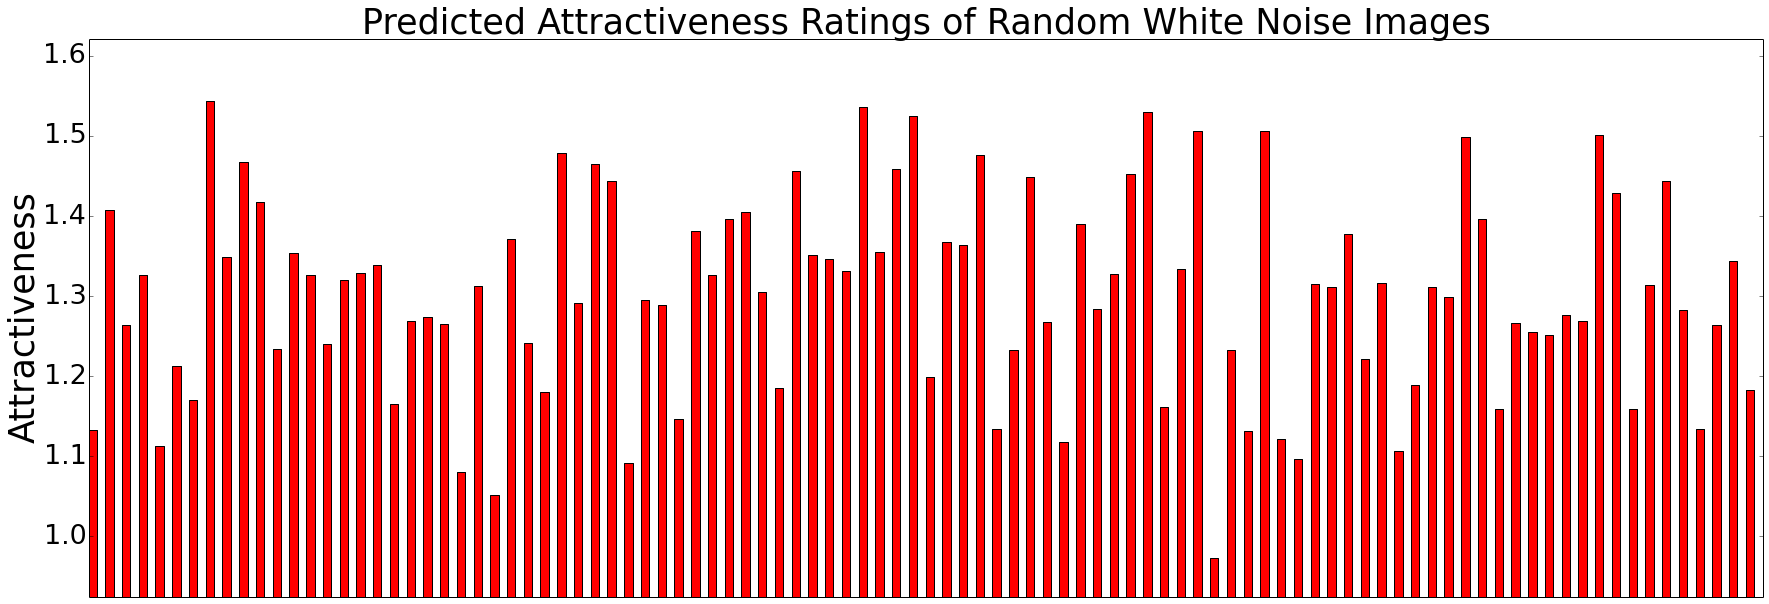

In [7]:
def autolabel(rects,ser):
    # attach some text labels
    max_label = max(ser)
    for rect, var in zip(rects, range(len(ser))):
        height = ser[var]
        if height > 0:
            ypos = 1.02*height
        else:
            ypos = 1.2*height
        if height == max_label:
            ax.text((rect.get_x() + rect.get_width()), ypos,
                    '(%.5f)' % (height), 
                    ha='center', va='bottom',fontsize = lSize-13)

N = pink_predict[::100].shape[0]
lSize = 35
ind = np.arange(N)  # the x locations for the groups
width = 0.5       # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(30, 10)
rects1 = ax.bar(ind, np.absolute(pink_predict[::100]), width, color='r')

#add some text for labels, title and axes ticks
ax.set_ylabel('Attractiveness',fontsize = lSize)
ax.set_title('Predicted Attractiveness Ratings of Random White Noise Images',fontsize = lSize)
ax.get_xaxis().set_visible(False)
ymin = 0.95*min(pink_predict[::100])
ymax = 1.05*max(pink_predict[::100])
ax.set_ylim([ymin,ymax])
# ax.set_xticks((ind + width/2)[::10])
# ax.set_xticklabels(range(1,N+1)[::10],fontsize = lSize-8,rotation=70)
ax.tick_params(axis='y', labelsize=lSize-8)

#autolabel(rects1,np.absolute(pink_predict[::100]))
plt.show()
#fig.savefig('../pink_noise_image/predicted_rating.png')



In [8]:

sortedIm = [x for (y,x) in sorted(zip(pink_predict,imList))]
sortedRating = [y for (y,x) in sorted(zip(pink_predict,imList))]

print sortedRating[0]
print sortedRating[-1]
sortedRating = np.asarray(sortedRating)
np.argwhere(sortedRating>1.2).shape

0.833025932312
1.87418961525


(7506, 1)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


min: 0.0 max: 255.0


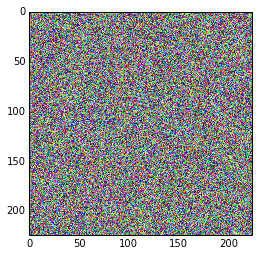

In [14]:
from PIL import Image
from matplotlib.pyplot import imshow
import cv2

def PIL2array(img):
    return np.array(img.getdata(),
                    np.uint8).reshape(img.size[1], img.size[0], 3)
def array2PIL(arr, size):
    mode = 'RGBA'
    arr = arr.reshape(arr.shape[0]*arr.shape[1], arr.shape[2])
    if len(arr[0]) == 3:
        arr = np.c_[arr, 255*np.ones((len(arr),1), np.uint8)]
    return Image.frombuffer(mode, size, arr.tostring(), 'raw', mode, 0, 1)


def sum_images(minRating):
    sum_arr = np.zeros((224,224,3))
    AllIm = np.argwhere(sortedRating>minRating)
    N = AllIm.shape[0]
    for index in AllIm:
        imName = sortedIm[index]
        img = Image.open(imName)
        im = cv2.imread(imName)
        #arr = PIL2array(img)
        
        sum_arr = sum_arr +im #*sortedRating[index]
    sum_arr = (sum_arr- np.min(sum_arr))/(np.max(sum_arr)-np.min(sum_arr))*255
    print 'min:',np.min(sum_arr),'max:', np.max(sum_arr)
    imshow(sum_arr)
#     img = loadImage('foo.jpg')
#     arr = PIL2array(img)
    #img2 = array2PIL(sum_arr, img.size)
    #cv2.imshow('Color image',sum_arr)
    #img2.save('sum'+str(minRating)+'.jpg')
minRating = sortedRating[0]
from scipy import stats
z_scoreRating = stats.zscore(sortedRating)
sum_images(minRating)

In [12]:
print 'Max:',sortedRating.max()
print 'Min:',sortedRating.min()
print 'Max:',z_scoreRating.max()
print 'Min:',z_scoreRating.min()
print z_scoreRating.std()

Max: 1.87418961525
Min: 0.833025932312
Max: 4.30629282779
Min: -3.37853907172
1.0
